In [94]:
import tensorflow as tf
import random
import os
import sys
import numpy as np
import torch
import logging
import argparse
import shutil
import cv2
import time
import threading
import multiprocessing
from pathlib import Path
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
from icecream import ic
from collections import defaultdict
import re

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(device_type='GPU', devices=gpus[0])

2022-02-17 07:20:17.066570: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-02-17 07:20:17.117942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2022-02-17 07:20:17.117979: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-17 07:20:17.118012: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-02-17 07:20:17.118024: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-02-17 07:20:17.118041: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10

In [4]:
!nvidia-smi

Thu Feb 17 06:54:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 495.44       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:1A:00.0 Off |                  Off |
| 30%   37C    P8    28W / 300W |     13MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# !pip install jupyterthemes -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 2.8 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 KB 277.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 11.6 MB/s eta 0:00:00


In [1]:
# !jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [3]:
path_to_file = tf.keras.utils.get_file(
    'Sarcasm_Headlines_Dataset.json',
    origin="http://aimaksen.bslience.cn/Sarcasm_Headlines_Dataset.json"
)

5619712/5616830 [==============================] - 15s 3us/step


In [4]:
path_to_file

'/root/.keras/datasets/Sarcasm_Headlines_Dataset.json'

In [9]:
# %ls Sources/

George_W_Bush_0001.jpg  Sarcasm_Headlines_Dataset.json


In [8]:
# !cp /root/.keras/datasets/Sarcasm_Headlines_Dataset.json Sources/

### pandas

In [13]:
df = pd.read_json(path_to_file, lines=True)
df

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


In [14]:
del df['article_link']

In [15]:
df

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
26704,american politics in moral free-fall,0
26705,america's best 20 hikes,0
26706,reparations and obama,0
26707,israeli ban targeting boycott supporters raise...,0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      26709 non-null  object
 1   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 417.5+ KB


### 查看样本的分布情况

In [17]:
import seaborn as sns

In [18]:
sns.set_style?

In [19]:
sns.set_style('dark')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

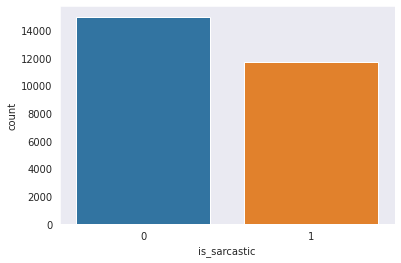

In [20]:
sns.countplot(df.is_sarcastic)

### 词云

In [21]:
# !pip install wordcloud -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.1/366.1 KB 567.3 kB/s eta 0:00:0000:0100:01


In [22]:
from wordcloud import WordCloud

In [27]:
wc = WordCloud(max_words=2000, width=1600, height=800).generate(
    " ".join(df[df.is_sarcastic==1].headline)
)

In [29]:
wc0 = WordCloud(max_words=2000, width=1600, height=800).generate(
    " ".join(df[df.is_sarcastic==0].headline)
)

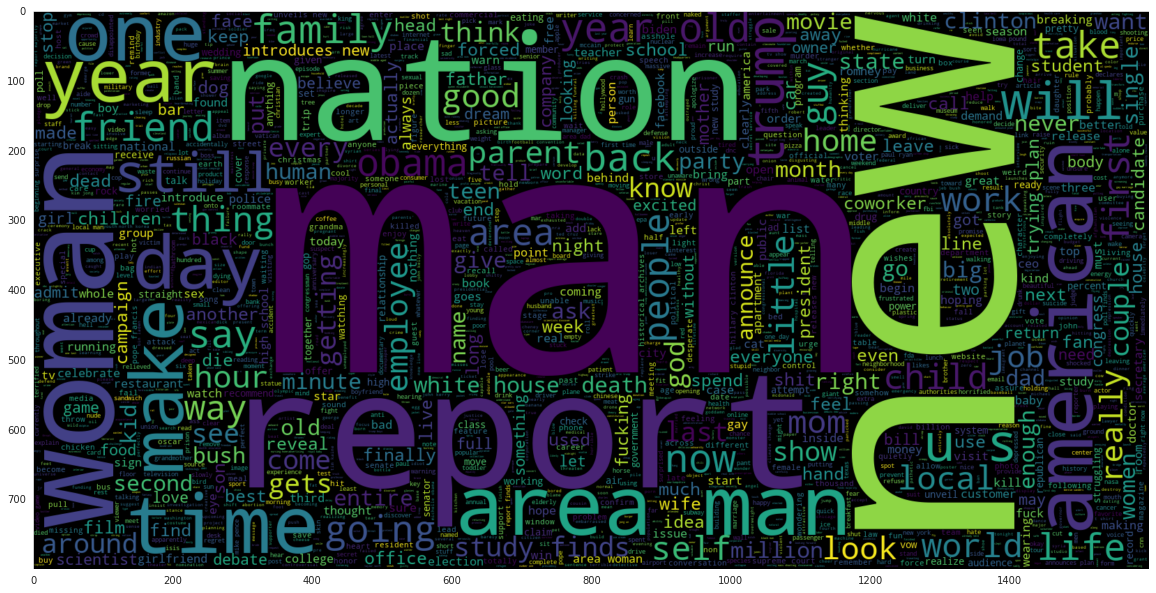

In [28]:
plt.figure(figsize=(20,20))
plt.imshow(wc, interpolation='bilinear')

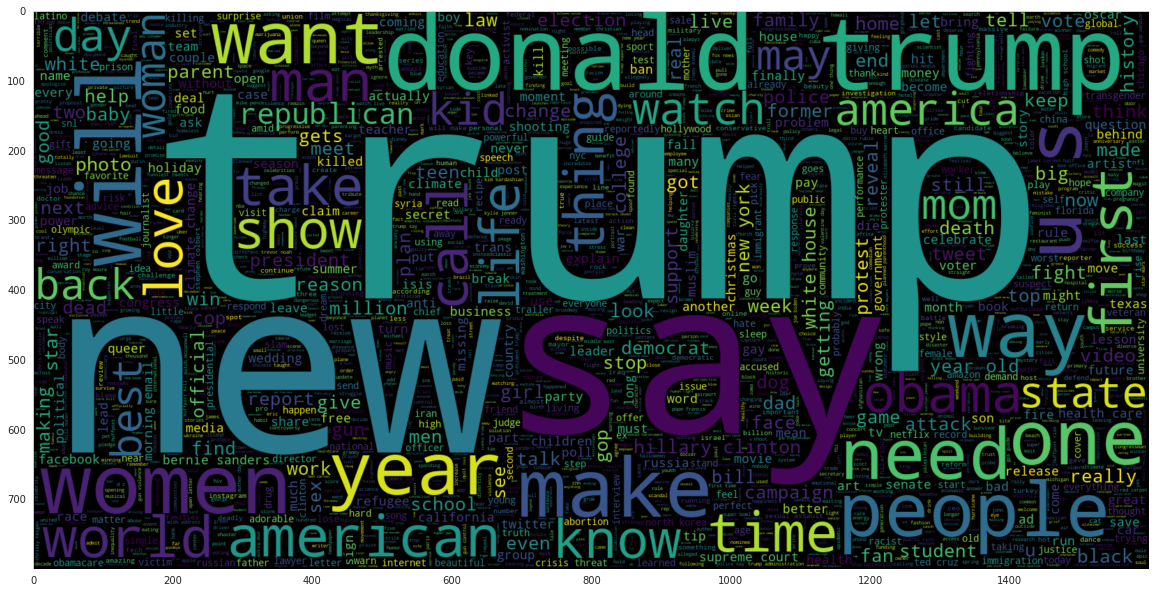

In [31]:
plt.figure(figsize=(20,20))
plt.imshow(wc0, interpolation='bilinear')

In [23]:
df[df.is_sarcastic==1].headline

2        mom starting to fear son's web series closest ...
3        boehner just wants wife to listen, not come up...
8        top snake handler leaves sinking huckabee camp...
15       nuclear bomb detonates during rehearsal for 's...
16       cosby lawyer asks why accusers didn't come for...
                               ...                        
26693    new bailiff tired of hearing how old bailiff d...
26694    breaking: 'the onion' in kill range of boston ...
26695    seaworld crowd applauds for dolphin playfully ...
26702    pentagon to withhold budget figures out of res...
26703    pope francis wearing sweater vestments he got ...
Name: headline, Length: 11724, dtype: object

In [24]:
" ".join(df[df.is_sarcastic==1].headline)

'mom starting to fear son\'s web series closest thing she will have to grandchild boehner just wants wife to listen, not come up with alternative debt-reduction ideas top snake handler leaves sinking huckabee campaign nuclear bomb detonates during rehearsal for \'spider-man\' musical cosby lawyer asks why accusers didn\'t come forward to be smeared by legal team years ago stock analysts confused, frightened by boar market courtroom sketch artist has clear manga influences trump assures nation that decision for syrian airstrikes came after carefully considering all his passing whims ex-con back behind bar after careful consideration, bush recommends oil drilling giant altoid heading toward earth robin williams inflicted on holiday moviegoers for eighth straight year rescuers heroically help beached garbage back into ocean christian bale visits sikh temple victims \'right to live life in complete, stunned horror,\' added to constitution nasa now almost positive mars is rocky monster unde

### 去除数据中的噪音（预处理）

In [32]:
import string
import nltk
from nltk.corpus import stopwords

In [37]:
stop = set(stopwords.words('english'))
pun = list(string.punctuation)
# stop
# pun
stop.update(pun)
stop

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'need

In [38]:
!pip install bs4 -i https://pypi.tuna.tsinghua.edu.cn/simple # html解析

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1271 sha256=914c4c010d8e068fba1035987f11c74831d04f96f5244190fd644278779428ea
  Stored in directory: /root/.cache/pip/wheels/fc/7c/a3/19eae03bb93ef3e2e59340cc1854aebdcb674091ac1c9dc314
Successfully built bs4


In [39]:
from bs4 import BeautifulSoup

In [40]:
def strip_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

In [56]:
def remove_special_tokens(text):
    return re.sub("[\{\}\(\)\[\]]", "", text)

In [62]:
a = "{a}(([helloworld])"
a = "hello"
remove_special_tokens(a)
# re.sub("[\{\}\(\)\[\]]", "", a)

'hello'

In [63]:
def remove_stopwords(text):
    final_text = []
    for i in text.split(" "):
        if i.strip().lower() in stop: continue
        final_text.append(i.strip())
    return " ".join(final_text)

In [64]:
def denoise_text(text):
    text = strip_html(text)
    text = remove_special_tokens(text)
    text = remove_stopwords(text)
    return text

In [65]:
df['headline_denoise']=df['headline'].apply(denoise_text)

In [67]:
df.head()

,headline,is_sarcastic,headline_denoise
0,former versace store clerk sues over secret 'b...,0,former versace store clerk sues secret 'black ...
1,the 'roseanne' revival catches up to our thorn...,0,'roseanne' revival catches thorny political mo...
2,mom starting to fear son's web series closest ...,1,mom starting fear son's web series closest thi...
3,"boehner just wants wife to listen, not come up...",1,"boehner wants wife listen, come alternative de..."
4,j.k. rowling wishes snape happy birthday in th...,0,j.k. rowling wishes snape happy birthday magic...


### 分词

In [142]:
sentences = df['headline_denoise'].values
sentences

array(["former versace store clerk sues secret 'black code' minority shoppers",
       "'roseanne' revival catches thorny political mood, better worse",
       "mom starting fear son's web series closest thing grandchild", ...,
       'reparations obama',
       'israeli ban targeting boycott supporters raises alarm abroad',
       'gourmet gifts foodie 2014'], dtype=object)

In [152]:
labels = df.is_sarcastic.values
labels.shape, labels

((26709,), array([0, 0, 1, ..., 0, 0, 0]))

In [144]:
training_size = 20000
training_sentences,test_sentences = sentences[:training_size], sentences[training_size:]
training_labels,test_labels = labels[:training_size], labels[training_size:]
training_sentences.shape, test_sentences.shape, training_labels.shape, test_labels.shape

((20000,), (6709,), (20000,), (6709,))

In [154]:
sentences

array(["former versace store clerk sues secret 'black code' minority shoppers",
       "'roseanne' revival catches thorny political mood, better worse",
       "mom starting fear son's web series closest thing grandchild", ...,
       'reparations obama',
       'israeli ban targeting boycott supporters raises alarm abroad',
       'gourmet gifts foodie 2014'], dtype=object)

In [145]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [146]:
tokenizer = Tokenizer(oov_token="") # out of vocabulary
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

In [147]:
word_index

{'': 1,
 'new': 2,
 'trump': 3,
 'man': 4,
 'one': 5,
 'report': 6,
 'year': 7,
 'area': 8,
 'donald': 9,
 'u': 10,
 'day': 11,
 'says': 12,
 's': 13,
 'first': 14,
 'woman': 15,
 'time': 16,
 'like': 17,
 "trump's": 18,
 'old': 19,
 'get': 20,
 'life': 21,
 'people': 22,
 'obama': 23,
 'house': 24,
 'still': 25,
 'women': 26,
 'make': 27,
 "'": 28,
 'white': 29,
 'back': 30,
 'clinton': 31,
 '5': 32,
 'world': 33,
 'could': 34,
 'americans': 35,
 'way': 36,
 'family': 37,
 'gop': 38,
 'study': 39,
 'school': 40,
 'black': 41,
 'best': 42,
 'years': 43,
 'bill': 44,
 '3': 45,
 'would': 46,
 'police': 47,
 'watch': 48,
 'american': 49,
 'really': 50,
 'last': 51,
 'know': 52,
 '10': 53,
 "can't": 54,
 'death': 55,
 'home': 56,
 'video': 57,
 'finds': 58,
 'state': 59,
 'president': 60,
 'health': 61,
 'going': 62,
 'say': 63,
 'show': 64,
 'nation': 65,
 'good': 66,
 'things': 67,
 'hillary': 68,
 "'the": 69,
 'may': 70,
 '2': 71,
 'campaign': 72,
 'every': 73,
 'love': 74,
 'mom': 75,


In [148]:
len(word_index)

29603

In [149]:
word_index

{'': 1,
 'new': 2,
 'trump': 3,
 'man': 4,
 'one': 5,
 'report': 6,
 'year': 7,
 'area': 8,
 'donald': 9,
 'u': 10,
 'day': 11,
 'says': 12,
 's': 13,
 'first': 14,
 'woman': 15,
 'time': 16,
 'like': 17,
 "trump's": 18,
 'old': 19,
 'get': 20,
 'life': 21,
 'people': 22,
 'obama': 23,
 'house': 24,
 'still': 25,
 'women': 26,
 'make': 27,
 "'": 28,
 'white': 29,
 'back': 30,
 'clinton': 31,
 '5': 32,
 'world': 33,
 'could': 34,
 'americans': 35,
 'way': 36,
 'family': 37,
 'gop': 38,
 'study': 39,
 'school': 40,
 'black': 41,
 'best': 42,
 'years': 43,
 'bill': 44,
 '3': 45,
 'would': 46,
 'police': 47,
 'watch': 48,
 'american': 49,
 'really': 50,
 'last': 51,
 'know': 52,
 '10': 53,
 "can't": 54,
 'death': 55,
 'home': 56,
 'video': 57,
 'finds': 58,
 'state': 59,
 'president': 60,
 'health': 61,
 'going': 62,
 'say': 63,
 'show': 64,
 'nation': 65,
 'good': 66,
 'things': 67,
 'hillary': 68,
 "'the": 69,
 'may': 70,
 '2': 71,
 'campaign': 72,
 'every': 73,
 'love': 74,
 'mom': 75,


In [81]:
from itertools import islice

In [151]:
list(islice(word_index.items(), 29600, 29604))

[('hikes', 29601), ('gourmet', 29602), ('foodie', 29603)]

In [86]:
training_sentences_id = tokenizer.texts_to_sequences(training_sentences)
test_sentences_id = tokenizer.texts_to_sequences(test_sentences)

In [155]:
training_sentences

array(["former versace store clerk sues secret 'black code' minority shoppers",
       "'roseanne' revival catches thorny political mood, better worse",
       "mom starting fear son's web series closest thing grandchild", ...,
       'clinton camp mastered science politics forgot art, staffers say',
       'nonprofit management usurp board responsibilities?',
       'pope francis attends outdoor mass cutoff denim vestments'],
      dtype=object)

In [157]:
word_index['former']

216

In [87]:
training_sentences_id


[[216, 15040, 572, 3235, 2192, 287, 2470, 15041, 2471, 8346],
 [8347, 3236, 2640, 8348, 318, 3008, 171, 901],
 [75, 734, 803, 1639, 1983, 476, 4626, 138, 10655],
 [1380, 140, 302, 1722, 227, 2820, 1288, 6875, 866],
 [659, 625, 4627, 804, 10656, 514, 488, 1204, 36],
 [10657, 272, 26],
 [6876, 259, 358, 4177, 2086, 1381],
 [376, 1064, 83, 40, 85, 260],
 [162, 3522, 6877, 449, 5182, 1887, 72],
 [1984, 235, 255, 303, 18, 15042, 3798],
 [2821, 1571, 4628, 4, 4178, 6878, 1985, 1000],
 [196, 677, 359, 1449, 1801, 3523],
 [150, 410, 2822, 3, 826, 142, 276, 4179, 15043, 8349],
 [152, 3799, 8350, 3237, 15044],
 [15045, 1289, 558, 544, 236, 930],
 [430, 1985, 10658, 10659, 10660, 4629, 1802],
 [2472, 1290, 288, 3800, 227, 931, 15046, 1001, 291, 43, 1205],
 [1572, 8351, 3009, 8352, 6879, 1115],
 [10661, 753, 1803, 171, 1065, 131, 2641],
 [3524, 5183, 3010],
 [8353, 3801, 754, 1382, 10662, 6880],
 [3, 1291, 65, 696, 626, 5184, 1116, 3238, 2473, 1723, 10663],
 [3802, 10664, 5868, 15, 2823, 15047, 46

In [89]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [123]:
# 要么这里减一，要么网络里加一
training_padded = pad_sequences(training_sentences_id, padding='post', maxlen=40)
test_padded = pad_sequences(test_sentences_id, padding='post', maxlen=40)

In [158]:
training_padded

array([[  216, 15040,   572, ...,     0,     0,     0],
       [ 8347,  3236,  2640, ...,     0,     0,     0],
       [   75,   734,   803, ...,     0,     0,     0],
       ...,
       [   31,  1424, 25884, ...,     0,     0,     0],
       [ 3963,  3761, 25885, ...,     0,     0,     0],
       [  206,   506,  8067, ...,     0,     0,     0]], dtype=int32)

In [125]:
test_padded.shape

(6709, 40)

In [119]:
# dir(pad_sequences)
pad_sequences?

### 构建模型

In [95]:
model = tf.keras.Sequential()

2022-02-22 03:27:21.648735: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-22 03:27:21.655090: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2022-02-22 03:27:21.656617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0
2022-02-22 03:27:21.658419: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-02-22 03:27:25.689927: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect Str

In [96]:
x = tf.constant([[3,4,5,6,7]])
x = tf.keras.layers.Embedding(len(word_index), 16)(x)
x

<tf.Tensor: shape=(1, 5, 16), dtype=float32, numpy=
array([[[-0.03736937, -0.01059513,  0.01434833, -0.01260829,
          0.04582332,  0.0180057 , -0.01534794, -0.00827328,
         -0.02492353,  0.03188462,  0.01434697,  0.03709774,
          0.02035875,  0.00600759,  0.03605688, -0.01958399],
        [-0.0021876 ,  0.01904669, -0.02659404,  0.03586439,
         -0.00155325,  0.00852698, -0.00338019, -0.03093106,
          0.01750371,  0.00314529,  0.00970848, -0.04349513,
         -0.04383693,  0.04959608,  0.04526443,  0.0190488 ],
        [ 0.00596694, -0.02352264,  0.02120015, -0.03186069,
         -0.01331822, -0.01873903, -0.04429635,  0.00982229,
         -0.00958025,  0.00240319, -0.03015224,  0.00042585,
          0.04377072, -0.01267917, -0.02516893, -0.02796747],
        [ 0.01268836,  0.02229139, -0.03125535, -0.04348434,
          0.04850996, -0.03072376, -0.04856865,  0.02975326,
          0.04732784, -0.01523713,  0.02168031,  0.01189393,
         -0.04244665,  0.00377

In [159]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(len(word_index)+1, 16))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(24, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.summary()
x = tf.constant([[3,4,5,6,7]])
y = model(x)
y

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 16)          473664    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 474,097
Trainable params: 474,097
Non-trainable params: 0
_________________________________________________________________


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.4989039]], dtype=float32)>

In [160]:
model.compile(
    loss='binary_crossentropy',
#     loss = tf.losses.binary_crossentropy
    optimizer = 'adam', 
    metrics=['accuracy']
)

### 训练

In [115]:
model.fit(training_padded, training_labels, epochs=20, verbose=1)

Epoch 1/20
625/625 [==============================] - 3s 5ms/step - loss: 0.2524 - accuracy: 0.9007
Epoch 2/20
625/625 [==============================] - 3s 5ms/step - loss: 0.1772 - accuracy: 0.9345
Epoch 3/20
625/625 [==============================] - 3s 5ms/step - loss: 0.1268 - accuracy: 0.9553
Epoch 4/20
625/625 [==============================] - 3s 5ms/step - loss: 0.0909 - accuracy: 0.9712
Epoch 5/20
625/625 [==============================] - 3s 5ms/step - loss: 0.0643 - accuracy: 0.9807
Epoch 6/20
625/625 [==============================] - 3s 5ms/step - loss: 0.0473 - accuracy: 0.9876
Epoch 7/20
625/625 [==============================] - 3s 5ms/step - loss: 0.0326 - accuracy: 0.9917
Epoch 8/20
625/625 [==============================] - 3s 5ms/step - loss: 0.0238 - accuracy: 0.9948
Epoch 9/20
625/625 [==============================] - 3s 5ms/step - loss: 0.0174 - accuracy: 0.9961
Epoch 10/20
625/625 [==============================] - 3s 5ms/step - loss: 0.0131 - accuracy: 0.9969

In [117]:
model.fit?

In [136]:
training_padded.shape, test_padded.shape, training_labels.shape, test_labels.shape


((20000, 40), (6709, 40), (20000,), (6709,))

In [137]:
test_padded2 = test_padded[:4000]
test_labels2 = test_labels[:4000]

In [161]:
model.fit(training_padded, training_labels, epochs=20, validation_data=(test_padded2, test_labels2), verbose=1)

Epoch 1/20
625/625 [==============================] - 4s 5ms/step - loss: 0.6654 - accuracy: 0.5847 - val_loss: 0.5987 - val_accuracy: 0.6712
Epoch 2/20
625/625 [==============================] - 3s 5ms/step - loss: 0.4431 - accuracy: 0.8167 - val_loss: 0.4334 - val_accuracy: 0.7968
Epoch 3/20
625/625 [==============================] - 3s 5ms/step - loss: 0.2869 - accuracy: 0.8860 - val_loss: 0.4482 - val_accuracy: 0.7915
Epoch 4/20
625/625 [==============================] - 3s 5ms/step - loss: 0.2083 - accuracy: 0.9232 - val_loss: 0.4761 - val_accuracy: 0.7972
Epoch 5/20
625/625 [==============================] - 3s 5ms/step - loss: 0.1557 - accuracy: 0.9452 - val_loss: 0.4612 - val_accuracy: 0.8073
Epoch 6/20
625/625 [==============================] - 3s 5ms/step - loss: 0.1170 - accuracy: 0.9609 - val_loss: 0.5045 - val_accuracy: 0.8045
Epoch 7/20
625/625 [==============================] - 3s 5ms/step - loss: 0.0894 - accuracy: 0.9724 - val_loss: 0.5458 - val_accuracy: 0.8010
Epoch 

In [162]:
model.fit(training_padded, training_labels, epochs=20, validation_data=(test_padded, test_labels), verbose=1)

Epoch 1/20
625/625 [==============================] - 4s 6ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 1.5065 - val_accuracy: 0.7724
Epoch 2/20
625/625 [==============================] - 3s 5ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 1.5759 - val_accuracy: 0.7712
Epoch 3/20
625/625 [==============================] - 3s 5ms/step - loss: 9.5697e-04 - accuracy: 0.9999 - val_loss: 1.6437 - val_accuracy: 0.7705
Epoch 4/20
625/625 [==============================] - 3s 6ms/step - loss: 9.4544e-04 - accuracy: 0.9999 - val_loss: 1.7209 - val_accuracy: 0.7699
Epoch 5/20
625/625 [==============================] - 3s 5ms/step - loss: 4.7778e-04 - accuracy: 1.0000 - val_loss: 1.7757 - val_accuracy: 0.7688
Epoch 6/20
625/625 [==============================] - 3s 6ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 1.8422 - val_accuracy: 0.7661
Epoch 7/20
625/625 [==============================] - 3s 5ms/step - loss: 4.5634e-04 - accuracy: 1.0000 - val_loss: 1.9012 - val_accurac

### 预测

In [178]:
predicted_sentences = [
    'game of thrones season final showing this sunday night',
    'granny starting to fear spiders in the garden might be real',
    'mom starting to fear son web series closest'
]

In [179]:
padded = pad_sequences(tokenizer.texts_to_sequences(predicted_sentences), padding='post', maxlen=40)
padded

array([[  176,  1111, 12446,   157,   665,  2881,  2150,  1491,   146,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [    1,   734,   672,   803, 21731,   527,  1278,  2586,   282,
         3642,   110,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [   75,   734,   672,   803,   197,  1983,   476,  4626,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]], dtype=int32)

In [173]:
word_index['spiders']

21731

In [180]:
model.predict(padded)

array([[2.0549521e-12],
       [2.7732325e-01],
       [9.9973196e-01]], dtype=float32)

### other

In [182]:
# !pip install tensorflow-datasets -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 109.6 kB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 KB 23.9 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.9/86.9 KB 104.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 KB 84.7 kB/s eta 0:00:00a 0:00:01
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21502 sha256=2cbd2ab64882bc2847409c06b427ae62ea8cc16ada3d6c2d669d697f86deb59b
  Stored in directory: /root/.cache/pip/wheels/0d/e2/ba/9339ab44963cfb977aa1056707cbcdaf238f72e8995695dddf
Successfully built promise


In [184]:
import tensorflow_datasets as tfds

In [ ]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True, )

2022-02-22 06:43:01.872199: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".
